#  第五章

本次作业我们加强对图神经网络的实践，包括GAT和GraphSAGE。具体地，我们需要（1）实现DGL中的GATConv，（2）利用DGL中的采样（Sampling）功能来部分完成GraphSAGE。

## 1. GAT 代码填空

GAT里的聚合过程可以表示为

$$\mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
\sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j}$$

其中节点i和节点j之间的注意力分数计算如下。注意分母里的节点是包含节点$i$自身的。

$$\alpha_{i,j} =
\frac{
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
\right)\right)}.$$

下面的代码并不遵循DGL的GATConv实现，而是按照上面公式实现的版本。DGL版本的GATConv使用了更加高效和更节省内存的实现，同时也更复杂和不容易理解，具体请参考链接：https://docs.dgl.ai/_modules/dgl/nn/pytorch/conv/gatconv.html#GATConv

*注意：*在DGL里对于边上的softmax计算有专门的函数[dgl.nn.functional.edge_softmax](https://docs.dgl.ai/generated/dgl.nn.functional.edge_softmax.html#dgl.nn.functional.edge_softmax)。在完成作业的时候，需要使用`edge_softmax`实现对每个节点按边进行softmax计算$\alpha_{i,j}$。

In [1]:
# set up session
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from dgl import function as fn
from dgl.nn.functional import edge_softmax

In [2]:
# t-SNE visualization utils
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

def plot_embedding(
    embeddings, labels, 
    title
):
    """plot node embedding with tSNE"""
    # fit tSNE:
    tsne = TSNE(n_components=2, init='pca', random_state=42)
    data = tsne.fit_transform(embeddings)
    
    # preprocess for visualization:
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
     
    # visualize:
    (V, _) = data.shape
    
    fig = plt.figure(figsize=(16, 9), dpi=80)
    ax = plt.subplot(111)
    for node_id in range(V):
        plt.text(
            data[node_id, 0], data[node_id, 1], str(labels[node_id]),
            color=plt.cm.Set1(labels[node_id] / 6),
            fontdict={'weight': 'bold', 'size': 9}
        )
        
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
    return fig

In [3]:
class GATConv(nn.Module):
    """ GATConv. API reference https://docs.dgl.ai/en/latest/generated/dgl.nn.pytorch.conv.GATConv.html
    """
    
    def __init__(
        self,
        in_feats,
        out_feats,
        num_heads,
        feat_drop=0.,
        attn_drop=0.,
        negative_slope=0.2,
        activation=None,
        bias=True
    ):
        super(GATConv, self).__init__()
        
        self.in_feats=in_feats
        self.num_heads = num_heads
        self.out_feats = out_feats
        
        # hidden layer:
        self.fc = nn.Linear(self.in_feats, out_feats * num_heads, bias=False)
        
        self.feat_drop = nn.Dropout(feat_drop)
        
        # multi-head attention layer:
        self.attn = nn.Parameter(
            torch.FloatTensor(size=(1, num_heads, 2*out_feats))
        )
        self.leaky_relu = nn.LeakyReLU(negative_slope)
        
        self.attn_drop = nn.Dropout(attn_drop)
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_feats,)))
        else:
            self.register_buffer('bias', None)

        self.activation = activation

        self.reset_parameters()
        
    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn, gain=gain)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)
    
    def forward(self, graph, feat):
        # 0. get current hidden layer
        feat_in = self.fc(feat).view(
            *feat.shape[:-1], 
            self.num_heads, self.out_feats
        )
        feat_in = self.feat_drop(feat_in)
        
        #
        # DGL message passing begin
        #
        graph.srcdata['h_in'] = feat_in
        
        # 1. 把转换后的特征赋到点上。通过自定义lambda方法把源和邻居节点的特征concat起来，存到边上
        u_cat_v = lambda edges: {
            'h_cat': torch.cat(
                tensors=(edges.dst['h_in'], edges.src['h_in']),
                dim=-1
            )
        }
        graph.apply_edges(u_cat_v)
        
        # 2. 取出边上的特征，进行多头attention转换，并做LeakyRelu计算
        a = (self.attn * graph.edata.pop('h_cat')).sum(dim=-1).unsqueeze(-1)
        a = self.leaky_relu(a)
            
        # 3. 使用DGL的edg_softmax函数完成按边的softmax计算
        a = edge_softmax(graph, a)
        
        # 4. 对softmax值做dropout后，赋给边
        graph.edata['a'] = self.attn_drop(a)
        
        # 5. 用softmax值和feat_head的特征，通过消息函数和聚合函数完成GAT的核心计算
        graph.update_all(
            fn.u_mul_e('h_in', 'a', 'h_weighed'),
            fn.sum('h_weighed', 'h_out')
        )
        
        #
        # DGL message passing end
        #
        feat_out = graph.dstdata['h_out']

        # 使用bias项
        if self.bias is not None:
            feat_out = feat_out + self.bias.view(*((1,) * len(feat.shape[:-1])), self.num_heads, self.out_feats)
        
        # 使用activation函数
        if self.activation:
            feat_out = self.activation(feat_out)

        return feat_out

In [4]:
class GAT(torch.nn.Module):
    """ 2层GAT.
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    heads: 注意力机制中的head数量
    attn_drop: 对注意力分数的dropout概率
    activation: 使用的激活函数
    with_bias: 是否带有偏置项
    """

    def __init__(
        self, 
        nfeat, 
        nhid, 
        nclass, 
        heads=8, 
        attn_drop=0.5, 
        activation=F.elu, # 按照原论文的设置，我们使用ELu作为激活函数
        with_bias=True
    ):
        super(GAT, self).__init__()

        self.conv1 = GATConv(
            in_feats=nfeat,
            out_feats=nhid,
            num_heads=heads,
            attn_drop=attn_drop, 
            activation=activation,
            bias=with_bias
        )

        self.conv2 = GATConv(
            in_feats=nhid * heads,
            out_feats=heads,
            num_heads=nclass,
            attn_drop=attn_drop, 
            activation=activation,
            bias=with_bias
        )

    def forward(self, g, features):
        h = self.conv1(g, features).flatten(1)   # flatten的目的是把多头attention的输出变换成一个头
        h = self.conv2(g, h).flatten(1)
        return F.log_softmax(h, dim=1)

    def initialize(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

In [5]:
def train(model, g, lr=0.01, weight_decay=5e-4, epochs=200):
    """ training
    """
    mask = g.ndata['train_mask']
    X = g.ndata['feat']
    Y_true = g.ndata['label']
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    for i in range(epochs):
        model.train()
        
        optimizer.zero_grad()
        Y_prob = model(g, X)

        loss = F.nll_loss(Y_prob[mask], Y_true[mask])
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            print('\tEpoch {}, training loss: {}'.format(i, loss.item()))
            
@torch.no_grad()
def test(model, g):
    """ evaluation on test set.
    """
    model.eval()
    
    mask = g.ndata['test_mask']
    
    X = g.ndata['feat']
    Y_true = g.ndata['label']
    
    # make predictions:
    Y_prob = model(g, X)
    Y_pred = Y_prob.argmax(1)
    
    # get loss:
    loss = F.nll_loss(Y_prob[mask], Y_true[mask]).item()
    # get accuracy:
    acc = Y_pred[mask].eq(Y_true[mask]).cpu().numpy().mean().item()
    
    print(
        "Evaluation results:",
        "\tloss= {:.4f}".format(loss),
        "\taccuracy= {:.4f}".format(acc)
    )
    
    return Y_pred[mask], Y_prob[mask], Y_true[mask], acc

In [6]:
import dgl
from dgl.data import CoraGraphDataset

dataset = CoraGraphDataset('./data') # 将数据保存在data文件夹下

g = dataset[0]
nclass = len(g.ndata['label'].unique())

# make the computing compatible with message passing pattern in DGL:
g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [7]:
device = 'cuda:0'

gat = GAT(
    nfeat=g.ndata['feat'].shape[1],
    nhid=8, 
    heads=8, 
    nclass=nclass
)

gat = gat.to(device)
g = g.to(device)

In [8]:
# test propagation:
sample_feat_output = gat(g, g.ndata['feat'])

print(sample_feat_output.shape)
print(sample_feat_output)

torch.Size([2708, 56])
tensor([[-4.0231, -4.0277, -4.0194,  ..., -4.0201, -4.0349, -4.0416],
        [-4.0265, -4.0312, -4.0252,  ..., -4.0227, -4.0252, -4.0328],
        [-4.0236, -4.0236, -4.0236,  ..., -4.0148, -4.0275, -4.0396],
        ...,
        [-4.0207, -4.0252, -4.0586,  ..., -4.0234, -4.0234, -4.0234],
        [-4.0141, -4.0454, -4.0369,  ..., -4.0044, -4.0145, -4.0384],
        [-4.0065, -4.0816, -4.0504,  ..., -4.0217, -4.0217, -4.0217]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [9]:
# training:
train(gat, g, epochs=200)
# evaluation:
pred, prob, true, acc = test(gat, g)

	Epoch 0, training loss: 4.02566385269165
	Epoch 20, training loss: 1.9599330425262451
	Epoch 40, training loss: 1.4890944957733154
	Epoch 60, training loss: 0.9493773579597473
	Epoch 80, training loss: 0.8178025484085083
	Epoch 100, training loss: 0.8408508896827698
	Epoch 120, training loss: 0.7280713319778442
	Epoch 140, training loss: 0.5888943076133728
	Epoch 160, training loss: 0.663342297077179
	Epoch 180, training loss: 0.5199535489082336
Evaluation results: 	loss= 0.7135 	accuracy= 0.7930


/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


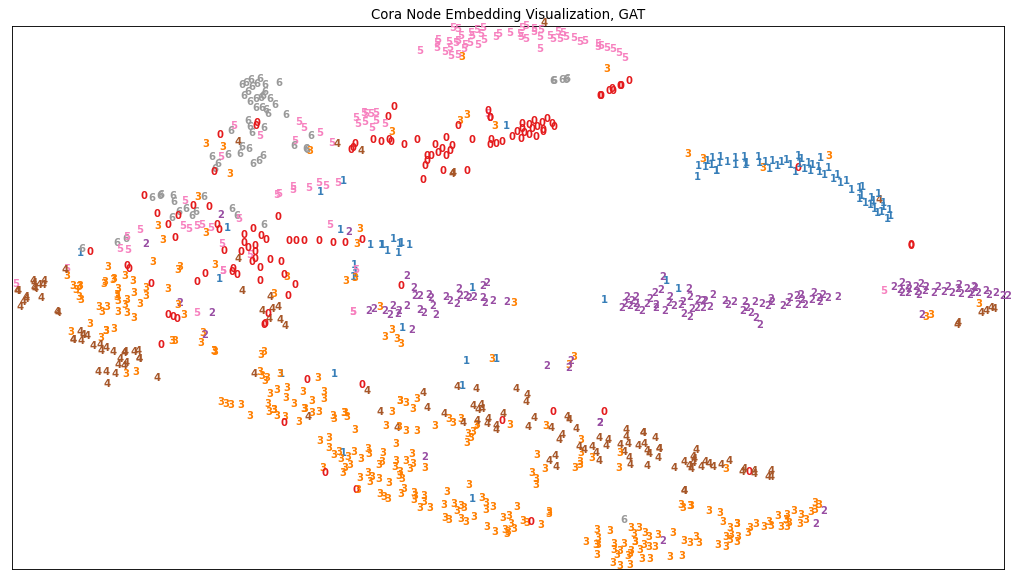

In [10]:
plt.show(
    plot_embedding(
        prob.cpu().numpy(), true.cpu().numpy(), 
        'Cora Node Embedding Visualization, GAT'
    )
)

## 2. GraphSage 代码填空

GraphSAGE的核心部分是采样（sampling）。我们利用DGL提供的MultiLayerNeighborSampler来实现采样功能，并使用DGL提供的NodeDataLoader来完成迷你批次样本的构建。

*注意：*MultiLayerNeighborSampler的入参fanouts表示的是对于每一阶邻居的采样的数量。例如，fanouts=\[10,5\]表示从一阶邻居里随机地采样10个邻居，再从这10个邻居的邻居(二阶邻居)里，随机采样5个邻居。更多的含义可以查看[DGL的MultiLayerNeighborSampler文档](https://docs.dgl.ai/api/python/dgl.dataloading.html#neighbor-sampler)。

这部分的代码填空很少，主要是希望同学们能够通过例子来学会使用MultiLayerNeighborSampler。关于使用DGL进行大图迷你批次训练的内容，可以查看DGL[《用户指南》](https://docs.dgl.ai/guide_cn/index.html)里的[第6章：在大图上的随机（批次）训练](https://docs.dgl.ai/guide_cn/minibatch.html)的内容

另外需要注意的是GraphSAGE中的聚合方式，它有两个变换矩阵：

$$ \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j
$$

In [11]:
# set up session:
import dgl

from dgl.data import CoraGraphDataset
from dgl.dataloading import MultiLayerNeighborSampler
from dgl.dataloading import NodeDataLoader

device = 'cuda:0'

In [12]:
# load dataset:
dataset = CoraGraphDataset('./data') # 将数据保存在data文件夹下

g = dataset[0]

g = g.to(device)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [13]:
train_idx = torch.arange(
    g.num_nodes()
)[g.ndata['train_mask']].to(device)

sampler = MultiLayerNeighborSampler(
    fanouts=[
        # num. of 1-hop neighbors:
        10,
        # num. of 2-hop neighbors:
        5
    ]
)

train_loader = NodeDataLoader(
    g, train_idx,
    sampler, batch_size=128,
    shuffle=True, num_workers=0
)

In [14]:
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    """ 2层GraphSAGE
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    dropout : dropout中的概率
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):
        super(GraphSAGE, self).__init__()
        
        self.convs = nn.ModuleList()
        # 这里我们使用平均`mean`来聚合邻居的特征，DGL的SAGEConv还有其他的聚合方法选择，比如`pool`,`lstm`。
        self.convs.append(
            SAGEConv(
                nfeat, 
                nhid, 
                aggregator_type='mean', 
                bias=with_bias, 
                activation=F.relu
            )
        )
        self.convs.append(
            SAGEConv(
                nhid, 
                nclass, 
                aggregator_type='mean', 
                bias=with_bias
            )
        )
        
        self.droput = dropout
        
    def reset_parameters(self):
        """ initialize params
        """
        for conv in self.convs:
            conv.reset_parameters()
            conv.reset_parameters()

    def forward(self, blocks, features):
        h = self.convs[0](blocks[0], features)
        h = F.dropout(h, p=self.droput, training=self.training)
        h = self.convs[1](blocks[1], h)

        return h.log_softmax(dim=-1)       
            
    def inference(self, g, features):
        """模型测试阶段的前向传播，不采样邻居节点，直接使用所有的邻居。可参考GCN中forward()的实现"""
        h = self.convs[0](g, features)
        h = F.dropout(h, p=self.droput, training=self.training)
        h = self.convs[1](g, h)
        
        return h.log_softmax(dim=-1) 

In [15]:
def train(model, g, train_loader, epochs, device='cpu', lr=0.01, weight_decay=5e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    features = g.ndata['feat'].to(device)
    labels = g.ndata['label'].to(device)
    
    for it in range(epochs):
        model.train()

        total_loss = 0
        for indices_feature, indices_label, mfgs in train_loader:
            # 'input_nodes' 是采样子图里所有节点的ID
            # 'seeds'是采样的种子节点ID，也是需要预测和计算loss的节点
            # 'mfgs':采样后的多层子图
            batch_features = features[indices_feature]
            batch_labels = labels[indices_label]
            mfgs = [mfg.to(device) for mfg in mfgs]

            out = model(mfgs, batch_features)
            loss = F.nll_loss(out, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        loss = total_loss / len(train_loader)
        if it % 10 ==0:
            print('Epoch:', it, 'training loss:', total_loss)


In [16]:
@torch.no_grad()
def test(model):
    """ Evaluation on test set.
    """
    # disable dropout for evaluation:
    model.eval()
    
    mask = g.ndata['test_mask']
    X = g.ndata['feat']
    Y_true = g.ndata['label']
    
    Y_prob = model.inference(g, X)
    Y_pred = Y_prob.argmax(1)
    
    loss = F.nll_loss(Y_prob[mask], Y_true[mask]).item()
    acc = Y_pred[mask].eq(Y_true[mask]).cpu().numpy().mean()
    
    print(
        "Evaluation Results:\n",
        "\tloss= {:.4f}".format(loss),
        "\taccuracy= {:.4f}".format(acc)
    )
    
    return Y_pred[mask], Y_prob[mask], Y_true[mask], acc

In [17]:
sage = GraphSAGE(
    nfeat=g.ndata['feat'].shape[1], 
    nhid=16, 
    nclass=len(g.ndata['label'].unique())
).to(device)

In [18]:
train(sage, g, train_loader, epochs=100, device=device)

pred, prob, true, acc = test(sage)

Epoch: 0 training loss: 3.9042117595672607
Epoch: 10 training loss: 2.905731201171875
Epoch: 20 training loss: 1.7415410876274109
Epoch: 30 training loss: 1.0911703705787659
Epoch: 40 training loss: 0.7680374085903168
Epoch: 50 training loss: 0.5393471866846085
Epoch: 60 training loss: 0.5556989908218384
Epoch: 70 training loss: 0.37888655066490173
Epoch: 80 training loss: 0.2671933099627495
Epoch: 90 training loss: 0.2514564022421837
Evaluation Results:
 	loss= 0.7384 	accuracy= 0.8020


/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda/envs/graph/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


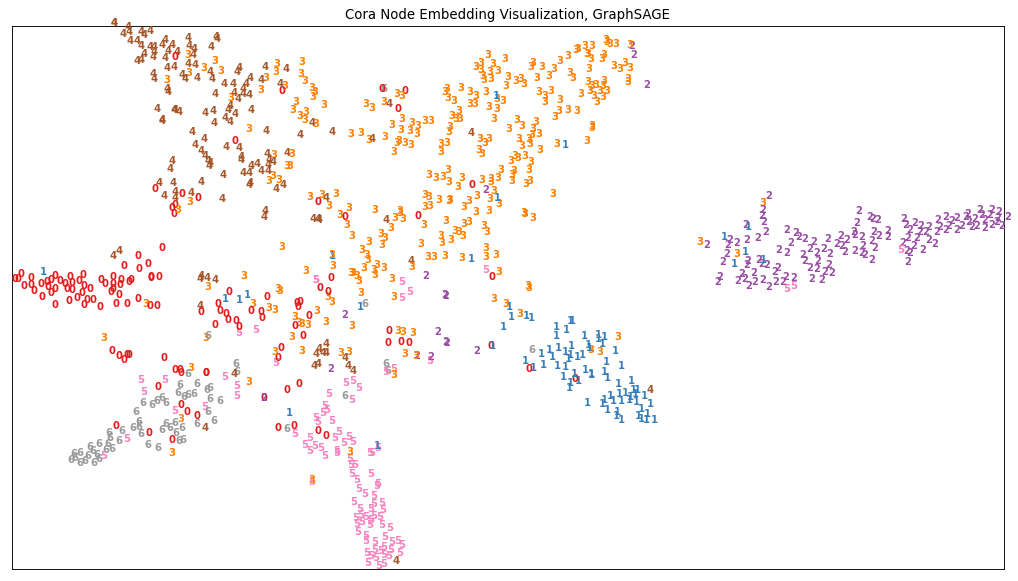

In [19]:
plt.show(
    plot_embedding(
        prob.cpu().numpy(), true.cpu().numpy(), 
        'Cora Node Embedding Visualization, GraphSAGE'
    )
)